# Empirical Assessment of Technical Analysis Indicators: High-frequency Data

## 0. Used packages

Apart from widely used packages, we'll employ package [ta](https://github.com/bukosabino/ta?source=post_page-----4b2b390d3543--------------------------------) which constructs technical indicators based on prices and volumes. The second package [mpl](https://github.com/matplotlib/mplfinance) is used for the interactive graph in Section 1.

In [89]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\dodac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:
import pandas as pd
import mplfinance as fplt
import plotly.graph_objects as go
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.volatility import DonchianChannel
from ta.trend import MACD
import matplotlib.pyplot as plt
import math

## 1. Introduction, Data Availability:

Intraday 1-minute data for the major stocks can be obtained free of charge in .csv format here: https://firstratedata.com/free-intraday-data. These serve as our initial source. Using data for major stocks (AAPL, AMAZN) and ETFs (SPDR S&P 500, SPDR DJIA) we construct a backtesting engine assessing the profitability of signals from technical analysis indicators.

In [80]:
df = pd.read_csv("AAPL_1min_firstratedata.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

#selecting a random day
day_df_1 = df[df['Date'].dt.date == pd.to_datetime("2022-10-19").date()].set_index("Date")

candlestick = go.Candlestick(x = day_df_1.index, open = day_df_1['Open'], high = day_df_1['High'], low = day_df_1['Low'], close = day_df_1['Close'])
fig = go.Figure(data=[candlestick])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

## 2. Patterns & Indicators

### 2.1 Volatility Indicators

#### Bollinger Bands (BB)

The Bollinger Bands are used to analyze the volatility of the price for an asset in a specific period of time. There are 3 bands, the Middle Band (MB) is the average of the price in the last n periods, the Upper (UB) and Lower Bands (LB) are equal to the middle band, but adding and subtracting x times the standard deviation. The default parameters chosen by us are n = 20 periods and x = 2.5.

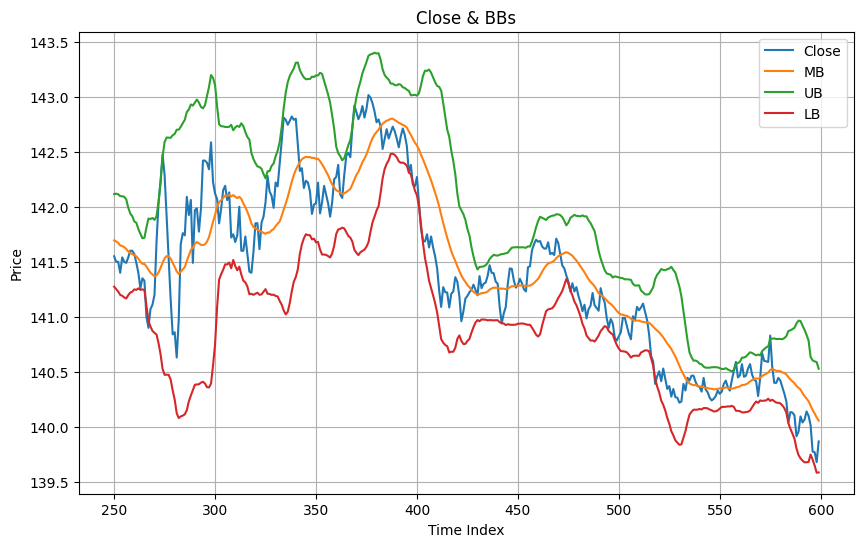

In [11]:
indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2.5)

df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbu'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

plot_df = df.iloc[250:600]

plt.figure(figsize=(10, 6))
plt.plot(plot_df['Close'], label='Close')
plt.plot(plot_df['bb_bbm'], label='MB')
plt.plot(plot_df['bb_bbu'], label='UB')
plt.plot(plot_df['bb_bbl'], label='LB')
plt.title('Close & BBs')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Donchian Channels

Similarly to Bollinger Bands, Donchian Channels consists of upper and lower bands, where the value of the upper band is equal to the highest price a stock sold for in the last n periods. Construction of the lower band follows the same logic. Although it is theoretically possible, closing prince never falls below the lower band and/or rise beyond the upper band. Strategy to buy/sell is therefore implemented the following way. We buy when the difference between the closing price and the lower band is less than 0.1% of the price. Conversely, we sell in case the price is less than 0.05% from the upper band. 

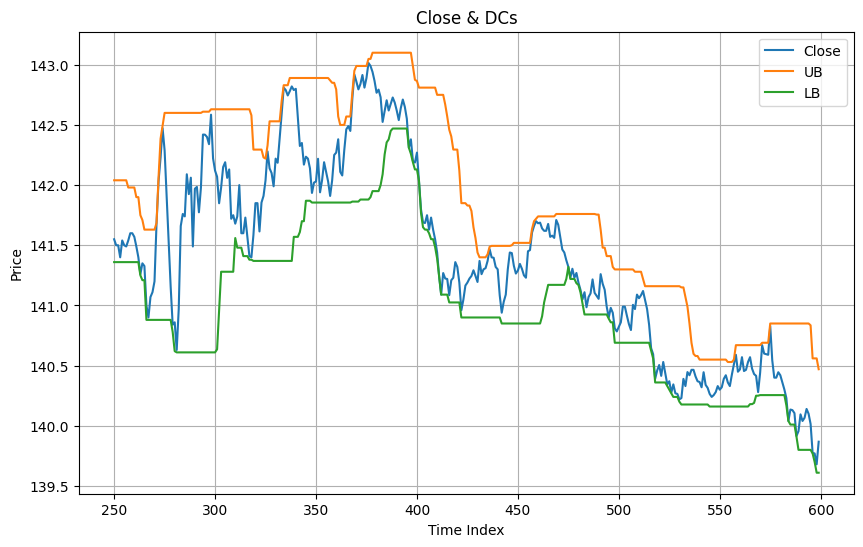

In [13]:
indicator_dc = DonchianChannel(high=df["High"], low=df["Low"], close=df["Close"], window=20)

df['dc_u'] = indicator_dc.donchian_channel_hband()
df['dc_l'] = indicator_dc.donchian_channel_lband()

plot_df = df.iloc[250:600]

plt.figure(figsize=(10, 6))
plt.plot(plot_df['Close'], label='Close')
plt.plot(plot_df['dc_u'], label='UB')
plt.plot(plot_df['dc_l'], label='LB')
plt.title('Close & DCs')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### 2.2 Trend Indicators

#### Moving Average Convergence Divergence (MACD)

MACD is one of the most used trend indicators. MACD line is constructed as a difference between n-period exponential moving average (EMA) of closing price and o-day EMA of closing price, where o > n. Signal line of MACD is then constructed as a p-day EMA of MACD line. According to the theory, one should buy when MACD line falls below the signal line and sell when it rises above it.

After trying various values of parameters, we opted for usually used values n = 12, o = 26 and p = 9.

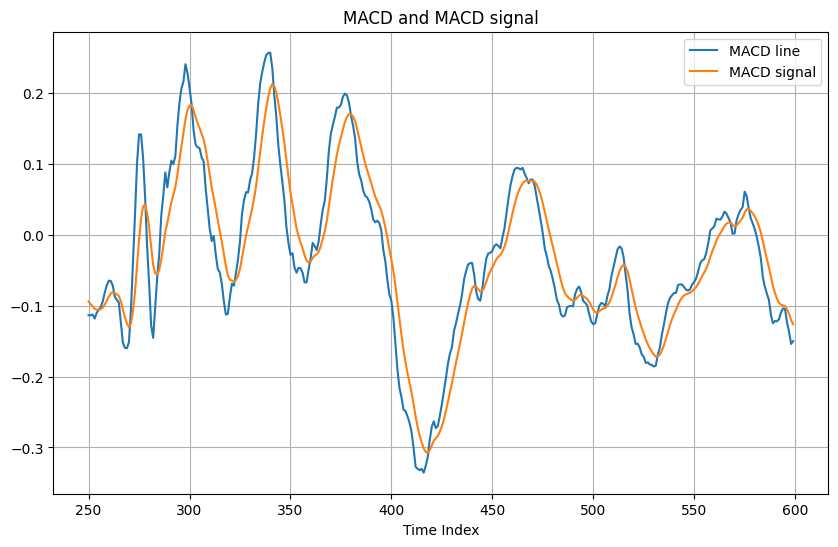

In [54]:
indicator_macd = MACD(close=df["Close"], window_fast = 12, window_slow = 26, window_sign = 9)

df['macd'] = indicator_macd.macd()
df['macd_sig'] = indicator_macd.macd_signal()

plot_df = df.iloc[250:600]

plt.figure(figsize=(10, 6))
#plt.plot(plot_df['Close'], label='Close')
plt.plot(plot_df['macd'], label='MACD line')
plt.plot(plot_df['macd_sig'], label='MACD signal')
plt.title('MACD and MACD signal')
plt.xlabel('Time Index')
plt.legend()
plt.grid(True)
plt.show()

### 3. Preprocessing Data and Backtesting

To make our code as user friendly as possible, we fit the whole code into two main functions: prepare and backtest. The prepare function takes raw data and constructs aforementioned indicators. The backtest function takes preprocessed data and performs backtesting.

In [74]:
def prepare(data):
    data['timestamp'] = pd.to_datetime(data['timestamp']) # transform time
    data.columns = ["Date", "Open", "High", "Low", "Close", "Volume"] # rename columns

    indicator_macd = MACD(close = data["Close"], window_fast = 12, window_slow = 26, window_sign = 9)
    indicator_dc = DonchianChannel(high = data["High"], low = data["Low"], close = data["Close"], window = 20)
    indicator_bb = BollingerBands(close = data["Close"], window = 20, window_dev = 2.5)

    data['bb_bbm'] = indicator_bb.bollinger_mavg()
    data['bb_bbu'] = indicator_bb.bollinger_hband()
    data['bb_bbl'] = indicator_bb.bollinger_lband()
    data['dc_u'] = indicator_dc.donchian_channel_hband()
    data['dc_l'] = indicator_dc.donchian_channel_lband()
    data['macd'] = indicator_macd.macd()
    data['macd_sig'] = indicator_macd.macd_signal()
    
    return data

In [68]:
def backtest(data, investment, method):
    
    in_position = False
    equity = investment
    counter = 0 # counting total number of times we sell
    bprice = 0 # temporarily saving buy price
    sprice = 0 # and sell price
    counter2 = 0 # to count the total number of realized profits
    
    # We provide more detailed comments only for the BB method. The rest of the methods are almost 1:1 copies.
    # The only difference is the way buy/sell conditions are specified 

    if method == "BB":

        for i in range(30, len(data)):
            if data['bb_bbl'][i] > data['Close'][i] and in_position == False: # specifying the condition to buy
                no_of_shares = math.floor(equity/data.Close[i]) # making the trade
                equity -= (no_of_shares * data.Close[i])
                in_position = True # indicating that we hold position
                bprice = data.Close[i] # temporarily saving the buy price
                #print('BUY: 'f'{no_of_shares} Shares are bought at ${data.Close[i]} on {str(data.Date[i])}')
        
            elif data['bb_bbu'][i] < data['Close'][i] and in_position == True: # specifying the condition to sell
                equity += (no_of_shares * data.Close[i]) # taking the profits
                in_position = False # indicating we no longer hold position
                sprice = data.Close[i]
                if bprice < sprice: # counting times of realized profit
                        counter2 += 1
                counter += 1 # counting total sells
                #print('SELL: ' f'{no_of_shares} Shares are sold at ${data.Close[i]} on {str(data.Date[i])}')
    
        if in_position == True:
            equity += (no_of_shares * data.Close[i])
            #print('Closing position at ' f'{data.Close[i]}' ' on ' f'{str(data.Date[i])}')
            in_position = False

    if method == "MACD":

        for i in range(30, len(data)):
            if data['macd'][i] < data['macd_sig'][i] and in_position == False:
                no_of_shares = math.floor(equity/data.Close[i])
                equity -= (no_of_shares * data.Close[i])
                in_position = True
                bprice = data.Close[i]
                #print('BUY: 'f'{no_of_shares} Shares are bought at ${data.Close[i]} on {str(data.Date[i])}')
        
            elif data['macd'][i] > data['macd_sig'][i] and in_position == True:
                equity += (no_of_shares * data.Close[i])
                in_position = False
                sprice = data.Close[i]
                if bprice < sprice:
                        counter2 += 1
                counter += 1
                #print('SELL: ' f'{no_of_shares} Shares are sold at ${data.Close[i]} on {str(data.Date[i])}')
    
        if in_position == True:
            equity += (no_of_shares * data.Close[i])
            #print('Closing position at ' f'{data.Close[i]}' ' on ' f'{str(data.Date[i])}')
            in_position = False


    #if method == "RSI"

        #for ...
            
    if method == "DC":

        for i in range(30, len(data)):
            if abs(data['dc_l'][i] - data['Close'][i]) < 0.0005 * data['Close'][i] and in_position == False:
                no_of_shares = math.floor(equity/data.Close[i])
                equity -= (no_of_shares * data.Close[i])
                in_position = True
                bprice = data.Close[i]
                #print('BUY: 'f'{no_of_shares} Shares are bought at ${data.Close[i]} on {str(data.Date[i])}')
        
            elif abs(data['dc_u'][i] - data['Close'][i]) < 0.0005 * data['Close'][i] and in_position == True:
                equity += (no_of_shares * data.Close[i])
                in_position = False
                sprice = data.Close[i]
                if bprice < sprice:
                        counter2 += 1
                counter += 1
                #print('SELL: ' f'{no_of_shares} Shares are sold at ${data.Close[i]} on {str(data.Date[i])}')
    
        if in_position == True:
            equity += (no_of_shares * data.Close[i])
            #print('Closing position at ' f'{data.Close[i]}' ' on ' f'{str(data.Date[i])}')
            in_position = False

    earning = round(equity - investment, 2) # total profit
    print('Trading using ' f'{method}' ' would yield:') # summary output
    print('Earning: ' f'{earning}')
    print('Total number of sells: ' f'{counter}')
    print('Out of that ' f'{counter2}' ' were profitable (' f'{round((counter2/counter)*100, 1)}' '%) ')

## 4. Results

To show the results in a more eye-pleasing way, we suppres the messages regarding buy and sell in the backtest function.

Interestingly, trading using Donchian channels yields the largest profits while having realtively low share of profitable sells. Our strategies also generate higher profits when trading individual major stocks than in case of ETFs.

Most importantly, given the timeframe tested and assuming no trading costs, we observe that there are money to be made by following relatively simple trading strategies.

In [82]:
AAPL_raw = pd.read_csv("AAPL_1min_firstratedata.csv")
AAPL = prepare(AAPL_raw)

AMZN_raw = pd.read_csv("AMZN_1min_firstratedata.csv")
AMZN = prepare(AMZN_raw)

DIA_raw = pd.read_csv("DIA_1min_firstratedata.csv")
DIA = prepare(DIA_raw)

SPY_raw = pd.read_csv("SPY_1min_firstratedata.csv")
SPY = prepare(SPY_raw)

#### AAPL

In [88]:
backtest(AAPL, 10000, method = "BB")
print("----------------------------------------")
backtest(AAPL, 10000, method = "MACD")
print("----------------------------------------")
backtest(AAPL, 10000, method = "DC")

Trading using BB would yield:
EARNING: 11966.59
Total number of sells: 1054
Out of that 741 were profitable (70.3%) 
----------------------------------------
Trading using MACD would yield:
EARNING: 23953.37
Total number of sells: 8164
Out of that 5651 were profitable (69.2%) 
----------------------------------------
Trading using DC would yield:
EARNING: 25262.52
Total number of sells: 9201
Out of that 5465 were profitable (59.4%) 


#### AMZN

In [85]:
backtest(AMZN, 10000, method = "BB")
print("----------------------------------------")
backtest(AMZN, 10000, method = "MACD")
print("----------------------------------------")
backtest(AMZN, 10000, method = "DC")

Trading using BB would yield:
EARNING: 19435.45
Total number of sells: 1060
Out of that 729 were profitable (68.8%) 
----------------
Trading using MACD would yield:
EARNING: 37342.49
Total number of sells: 8422
Out of that 5946 were profitable (70.6%) 
Trading using DC would yield:
EARNING: 42039.23
Total number of sells: 6367
Out of that 4277 were profitable (67.2%) 


#### SPY

In [86]:
backtest(SPY, 10000, method = "BB")
print("----------------------------------------")
backtest(SPY, 10000, method = "MACD")
print("----------------------------------------")
backtest(SPY, 10000, method = "DC")

Trading using BB would yield:
EARNING: 3783.29
Total number of sells: 1083
Out of that 705 were profitable (65.1%) 
------------------------------
Trading using MACD would yield:
EARNING: 8377.04
Total number of sells: 8532
Out of that 5797 were profitable (67.9%) 
------------------------------
Trading using DC would yield:
EARNING: 6348.69
Total number of sells: 18722
Out of that 9948 were profitable (53.1%) 


#### DIA

In [87]:
backtest(DIA, 10000, method = "BB")
print("----------------------------------------")
backtest(SPY, 10000, method = "MACD")
print("----------------------------------------")
backtest(SPY, 10000, method = "DC")

Trading using BB would yield:
EARNING: 2791.97
Total number of sells: 639
Out of that 424 were profitable (66.4%) 
------------------------------
Trading using MACD would yield:
EARNING: 8377.04
Total number of sells: 8532
Out of that 5797 were profitable (67.9%) 
------------------------------
Trading using DC would yield:
EARNING: 6348.69
Total number of sells: 18722
Out of that 9948 were profitable (53.1%) 
